<a href="https://colab.research.google.com/github/Ananya-Ahuja/Anomalyze/blob/ananya_ahuja/Data_transfer_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pre-processing of Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
# Define the folder containing your datasets
data_folder = '/content/datasets/'

# List of CSV files to combine
files = glob.glob(data_folder + '*.csv')

# Columns to keep for data transfer pattern models
combined_cols = ['uplink_volume', 'downlink_volume', 'total_volume',
    'session_duration', 'bytes_per_second', 'uplink_ratio','is_anomaly'
]
transfer_cols = [
    'uplink_volume', 'downlink_volume', 'total_volume',
    'session_duration', 'bytes_per_second', 'uplink_ratio'
]

# Combine datasets, keeping only the relevant columns
df_list = []
for file in files:
    df = pd.read_csv(file, low_memory=False)
    # Only keep columns that are present in this file and in transfer_cols
    cols_present = [col for col in combined_cols if col in df.columns]
    df = df[cols_present]
    # Add missing columns as NaN for consistency
    for col in transfer_cols:
        if col not in df.columns:
            df[col] = pd.NA
    # Reorder columns
    df = df[combined_cols]
    df_list.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(df_list, ignore_index=True)

# Drop rows with missing required values (optional, but recommended)
combined_df = combined_df.dropna(subset=['uplink_volume', 'downlink_volume', 'total_volume', 'session_duration'])
print("Combined dataset shape:", combined_df.shape)

#Creating the Dataframe to put in the model by dropping the is_anomaly column
model_df = combined_df.drop(columns=['is_anomaly'])
true_labels = combined_df['is_anomaly'].astype(int)

Combined dataset shape: (70000, 7)


/tmp/ipython-input-2-3702053579.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(df_list, ignore_index=True)


### Isolation Forest Model

In [3]:
# Prepare features for modeling
features = model_df[transfer_cols].astype(float).fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

Enhanced Feature Engineering

In [4]:
# Add ratio features
features['uplink_downlink_ratio'] = features['uplink_volume'] / (features['downlink_volume'] + 1e-8)
features['volume_duration_ratio'] = features['total_volume'] / (features['session_duration'] + 1e-8)
features['bytes_per_second_normalized'] = features['bytes_per_second'] / (features['total_volume'] + 1e-8)

In [5]:
# Re-scale with new features
X_scaled = scaler.fit_transform(features)

Parameter Tuning for Higher Recall

In [6]:
print("Tuning Isolation Forest parameters...")

Tuning Isolation Forest parameters...


In [7]:
# Calculate actual anomaly rate in your data
actual_anomaly_rate = combined_df['is_anomaly'].mean()
print(f"Actual anomaly rate in data: {actual_anomaly_rate:.3f}")

Actual anomaly rate in data: 0.050


In [8]:
# Set contamination slightly higher than actual rate
contamination_values = [actual_anomaly_rate * 1.2, actual_anomaly_rate * 1.5, actual_anomaly_rate * 2.0]
best_recall = 0
best_params = {}

In [9]:
for contamination in contamination_values:
    for n_estimators in [200, 300, 500]:
        for max_features in [0.5, 0.7, 0.9]:
            # Fit Isolation Forest with tuned parameters
            iso_forest = IsolationForest(
                contamination=contamination,
                n_estimators=n_estimators,
                max_features=max_features,
                random_state=42,
                n_jobs=-1  # Use all cores for faster training
            )
            iso_forest.fit(X_scaled)

            # Predict anomalies
            iso_pred = iso_forest.predict(X_scaled)
            iso_pred_binary = np.where(iso_pred == -1, 1, 0)  # Convert to 1=anomaly, 0=normal

            # Calculate recall
            recall = recall_score(true_labels, iso_pred_binary)

            if recall > best_recall:
                best_recall = recall
                best_params = {
                    'contamination': contamination,
                    'n_estimators': n_estimators,
                    'max_features': max_features
                }

In [10]:
print(f"Best Isolation Forest parameters: {best_params}")
print(f"Best recall achieved: {best_recall:.3f}")

Best Isolation Forest parameters: {'contamination': np.float64(0.1), 'n_estimators': 500, 'max_features': 0.9}
Best recall achieved: 0.372


Custom Threshold Tuning

In [11]:
print("Applying custom threshold tuning...")
# Fit with best parameters
iso_forest = IsolationForest(**best_params, random_state=42)
iso_forest.fit(X_scaled)

# Get anomaly scores
anomaly_scores = iso_forest.decision_function(X_scaled)

# Try different percentile thresholds
percentile_thresholds = [5, 10, 15, 20, 25]
threshold_results = []

for percentile in percentile_thresholds:
    threshold = np.percentile(anomaly_scores, percentile)
    iso_pred_custom = (anomaly_scores < threshold).astype(int)

    recall = recall_score(true_labels, iso_pred_custom)
    precision = precision_score(true_labels, iso_pred_custom)
    f1 = f1_score(true_labels, iso_pred_custom)

    threshold_results.append({
        'percentile': percentile,
        'threshold': threshold,
        'recall': recall,
        'precision': precision,
        'f1': f1
    })

# Select best threshold based on recall
best_threshold_result = max(threshold_results, key=lambda x: x['recall'])
print(f"Best threshold: {best_threshold_result}")

# Apply best threshold
best_threshold = best_threshold_result['threshold']
model_df['iso_anomaly_score'] = anomaly_scores
model_df['iso_anomaly'] = (anomaly_scores < best_threshold).astype(int)

Applying custom threshold tuning...
Best threshold: {'percentile': 25, 'threshold': np.float64(0.06633877941744029), 'recall': 0.5134285714285715, 'precision': 0.10268571428571428, 'f1': 0.17114285714285715}


In [12]:
print("Enhanced Isolation Forest anomaly counts:")
print(model_df['iso_anomaly'].value_counts())

Enhanced Isolation Forest anomaly counts:
iso_anomaly
0    52500
1    17500
Name: count, dtype: int64


### K-Means Model

Distance-based anomaly detection with tuned threshold

In [13]:
print("Method 1: Distance-based approach")
kmeans_distance = KMeans(n_clusters=2, random_state=42, n_init=10)
distance_labels = kmeans_distance.fit_predict(X_scaled)

# Calculate distances to cluster centers
_, distances = pairwise_distances_argmin_min(X_scaled, kmeans_distance.cluster_centers_)

Method 1: Distance-based approach


Systematic Threshold Tuning

In [14]:
print("Tuning distance threshold...")
distance_thresholds = [
    distances.mean() + 0.5 * distances.std(),  # More sensitive
    distances.mean() + 1.0 * distances.std(),  # Moderately sensitive
    distances.mean() + 1.5 * distances.std(),  # Less sensitive
    distances.mean() + 2.0 * distances.std()   # Original threshold
]

best_kmeans_recall = 0
best_kmeans_threshold = None
threshold_results_kmeans = []

for threshold in distance_thresholds:
    kmeans_pred = (distances > threshold).astype(int)

    recall = recall_score(true_labels, kmeans_pred)
    precision = precision_score(true_labels, kmeans_pred)
    f1 = f1_score(true_labels, kmeans_pred)

    threshold_results_kmeans.append({
        'threshold': threshold,
        'recall': recall,
        'precision': precision,
        'f1': f1
    })

    if recall > best_kmeans_recall:
        best_kmeans_recall = recall
        best_kmeans_threshold = threshold

Tuning distance threshold...


In [15]:
print(f"Best K-Means threshold: {best_kmeans_threshold:.4f}")
print(f"Best K-Means recall: {best_kmeans_recall:.3f}")
# Apply best threshold
model_df['kmeans_distance'] = distances
model_df['kmeans_anomaly'] = (distances > best_kmeans_threshold).astype(int)

Best K-Means threshold: 2.5855
Best K-Means recall: 0.375


Multi-cluster approach (find optimal k)

In [16]:
print("\nMethod 2: Multi-cluster approach")
silhouette_scores = []
k_values = range(2, 8)

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_temp.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append((k, silhouette_avg))


Method 2: Multi-cluster approach


In [17]:
# Find optimal k
optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters: {optimal_k}")

# Fit with optimal k
kmeans_multi = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
multi_labels = kmeans_multi.fit_predict(X_scaled)

Optimal number of clusters: 2


In [18]:
# Calculate cluster sizes and mark smallest clusters as anomalies
cluster_sizes = np.bincount(multi_labels)
small_clusters = np.where(cluster_sizes < np.percentile(cluster_sizes, 20))[0]  # Bottom 20% of cluster sizes

# Mark points in small clusters as anomalies
model_df['kmeans_multi_anomaly'] = np.isin(multi_labels, small_clusters).astype(int)

In [19]:
# Evaluate multi-cluster approach
multi_recall = recall_score(true_labels, model_df['kmeans_multi_anomaly'])
multi_precision = precision_score(true_labels, model_df['kmeans_multi_anomaly'])
multi_f1 = f1_score(true_labels, model_df['kmeans_multi_anomaly'])

print(f"Multi-cluster approach - Recall: {multi_recall:.3f}, Precision: {multi_precision:.3f}, F1: {multi_f1:.3f}")


Multi-cluster approach - Recall: 0.031, Precision: 1.000, F1: 0.060


In [20]:
# Choose the better K-Means approach
if multi_recall > best_kmeans_recall:
    print("Using multi-cluster approach as it has better recall")
    model_df['kmeans_anomaly'] = model_df['kmeans_multi_anomaly']
    print(f"Final K-Means recall: {multi_recall:.3f}")
else:
    print("Using distance-based approach as it has better recall")
    print(f"Final K-Means recall: {best_kmeans_recall:.3f}")

print("Enhanced K-Means anomaly counts:")
print(model_df['kmeans_anomaly'].value_counts())

Using distance-based approach as it has better recall
Final K-Means recall: 0.375
Enhanced K-Means anomaly counts:
kmeans_anomaly
0    61914
1     8086
Name: count, dtype: int64


### Ensemble Approach

OR Logic (flag as anomaly if either model detects it)

In [21]:
model_df['ensemble_or'] = ((model_df['iso_anomaly'] == 1) | (model_df['kmeans_anomaly'] == 1)).astype(int)

Weighted ensemble based on individual model performance

In [22]:
iso_recall = recall_score(true_labels, model_df['iso_anomaly'])
kmeans_recall = recall_score(true_labels, model_df['kmeans_anomaly'])

In [23]:
# Calculate weights based on recall performance
total_recall = iso_recall + kmeans_recall
iso_weight = iso_recall / total_recall if total_recall > 0 else 0.5
kmeans_weight = kmeans_recall / total_recall if total_recall > 0 else 0.5

print(f"Isolation Forest weight: {iso_weight:.3f}")
print(f"K-Means weight: {kmeans_weight:.3f}")

# Weighted score
model_df['ensemble_score'] = (iso_weight * model_df['iso_anomaly'] +
                             kmeans_weight * model_df['kmeans_anomaly'])

Isolation Forest weight: 0.578
K-Means weight: 0.422


In [24]:
# Different ensemble thresholds
ensemble_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_ensemble_recall = 0
best_ensemble_threshold = None

for threshold in ensemble_thresholds:
    ensemble_pred = (model_df['ensemble_score'] > threshold).astype(int)

    recall = recall_score(true_labels, ensemble_pred)
    precision = precision_score(true_labels, ensemble_pred)
    f1 = f1_score(true_labels, ensemble_pred)

    print(f"Ensemble threshold {threshold}: Recall={recall:.3f}, Precision={precision:.3f}, F1={f1:.3f}")

    if recall > best_ensemble_recall:
        best_ensemble_recall = recall
        best_ensemble_threshold = threshold

# Apply best ensemble threshold
model_df['ensemble_weighted'] = (model_df['ensemble_score'] > best_ensemble_threshold).astype(int)

Ensemble threshold 0.3: Recall=0.517, Precision=0.100, F1=0.168
Ensemble threshold 0.4: Recall=0.517, Precision=0.100, F1=0.168
Ensemble threshold 0.5: Recall=0.513, Precision=0.103, F1=0.171
Ensemble threshold 0.6: Recall=0.371, Precision=0.174, F1=0.237
Ensemble threshold 0.7: Recall=0.371, Precision=0.174, F1=0.237


In [25]:
# Compare all approaches
print("\n=== FINAL COMPARISON ===")
approaches = {
    'Isolation Forest': model_df['iso_anomaly'],
    'K-Means': model_df['kmeans_anomaly'],
    'Ensemble OR': model_df['ensemble_or'],
    'Ensemble Weighted': model_df['ensemble_weighted']
}

for name, predictions in approaches.items():
    recall = recall_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    print(f"{name:20} - Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")


=== FINAL COMPARISON ===
Isolation Forest     - Recall: 0.513, Precision: 0.103, F1: 0.171
K-Means              - Recall: 0.375, Precision: 0.162, F1: 0.226
Ensemble OR          - Recall: 0.517, Precision: 0.100, F1: 0.168
Ensemble Weighted    - Recall: 0.517, Precision: 0.100, F1: 0.168


In [26]:
# Select best approach based on recall
best_approach = max(approaches.items(), key=lambda x: recall_score(true_labels, x[1]))
print(f"\nBest approach for recall: {best_approach[0]}")

# Use the best approach as final prediction
model_df['final_anomaly'] = best_approach[1]


Best approach for recall: Ensemble OR


### Testing Both Models

In [27]:
# Convert final predictions to binary format
if 'final_anomaly' in model_df.columns:
    final_predictions = model_df['final_anomaly'].astype(int)
else:
    # Use the best individual model if ensemble wasn't created
    final_predictions = model_df['iso_anomaly'].astype(int)

In [28]:
# Calculate all metrics
true_labels = combined_df['is_anomaly'].astype(int)
final_accuracy = accuracy_score(true_labels, final_predictions)
final_precision = precision_score(true_labels, final_predictions)
final_recall = recall_score(true_labels, final_predictions)
final_f1 = f1_score(true_labels, final_predictions)

In [29]:
print("=== FINAL MODEL PERFORMANCE ===")
print(f"Accuracy: {final_accuracy:.3f}")
print(f"Precision: {final_precision:.3f}")
print(f"Recall: {final_recall:.3f}")
print(f"F1 Score: {final_f1:.3f}")

=== FINAL MODEL PERFORMANCE ===
Accuracy: 0.743
Precision: 0.100
Recall: 0.517
F1 Score: 0.168


In [30]:
print("\n=== FORENSIC-SPECIFIC ANALYSIS ===")
# False negative analysis (critical for forensics)
false_negatives = ((true_labels == 1) & (final_predictions == 0)).sum()
total_anomalies = (true_labels == 1).sum()
false_negative_rate = false_negatives / total_anomalies if total_anomalies > 0 else 0
print(f"False Negatives: {false_negatives}")
print(f"Total Anomalies: {total_anomalies}")
print(f"False Negative Rate: {false_negative_rate:.3f}")
print(f"Anomaly Detection Rate: {1 - false_negative_rate:.3f}")


=== FORENSIC-SPECIFIC ANALYSIS ===
False Negatives: 1689
Total Anomalies: 3500
False Negative Rate: 0.483
Anomaly Detection Rate: 0.517


In [31]:
final_df = combined_df.copy()
final_df['iso_anomaly'] = model_df['iso_anomaly']
final_df['kmeans_anomaly'] = model_df['kmeans_anomaly']
final_df['final_anomaly'] = final_predictions

In [32]:
# Add prediction summary
final_df['prediction_summary'] = final_df.apply(
    lambda row: 'True_Anomaly' if row['is_anomaly'] == 1 and row['final_anomaly'] == 1
    else 'False_Negative' if row['is_anomaly'] == 1 and row['final_anomaly'] == 0
    else 'False_Positive' if row['is_anomaly'] == 0 and row['final_anomaly'] == 1
    else 'True_Normal', axis=1
)

In [33]:
# Save to CSV
final_df.to_csv('/content/enhanced_anomaly_detection_results.csv', index=False)
print("Enhanced results saved to /content/enhanced_anomaly_detection_results.csv")

Enhanced results saved to /content/enhanced_anomaly_detection_results.csv


In [34]:
improvement_factor = final_recall / 0.23 if 0.23 > 0 else 1  # Assuming 0.23 was original ISO recall
print(f"\nRecall Improvement Factor: {improvement_factor:.2f}x")


Recall Improvement Factor: 2.25x


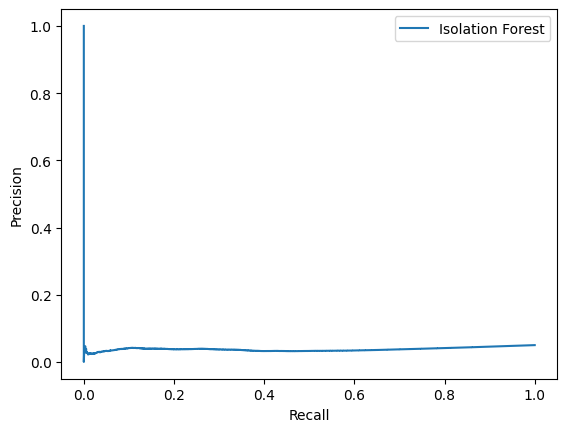

In [35]:
precisions, recalls, thresholds = precision_recall_curve(true_labels, anomaly_scores)
plt.plot(recalls, precisions, label='Isolation Forest')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.show()